# Final Year Project - Emoji Inset Creator Section

## Overview

In this section, a dataset is created containing three different types of images:

- Images with one emoji
- Images with two emojis
- Images with three emojis

The original images and emojis are retrieved and stored in dictionaries. The emojis are then added to the images and the resulting images are then saved in the EmojiImagesOne, EmojiImagesTwo and EmojiImagesThree folders respectively.

## Installing / Importing Packages

The following packages are required for the notebook to work.

In [1]:
#Installing and Importing Packages
from matplotlib import pyplot as plt
import cv2
import os
import math
from random import *
import tensorflow as tf
import tensorflow_addons as tfa
from random import choice, randint, uniform
import seaborn as sns
import csv
from xml.dom.minidom import parseString
from xml.etree.ElementTree import ElementTree, Element, SubElement, tostring

c:\Users\icemo\anaconda3\envs\fyp\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Creating Dictionary of Images

The images are retrieved from the Stock Images folder and stored in the images dictionary. Each image is also displayed to the user.

In [2]:
#Creating dictionary for images
images = {}
counter = 1

#Prompting User to Choose Dataset
datasetChosen = int(input("Which Dataset do you want to use: \n1. COCO Dataset\n2. Alternative Dataset\n"))

match datasetChosen:
    case 1:
        counter = 0
        #COCO DATASET DIRECTORY - CHANGE THIS TO YOUR DIRECTORY
        cocoDataset = "COCODataset/validation/data/"
        for image in os.listdir(cocoDataset):
            if counter >= 1500:
                break
            images["Image" + str(counter)] = cv2.imread(cocoDataset + image)[:,:,::-1]
            counter += 1
    case 2:
        #ALTERNATIVE DATASET DIRECTORY - CHANGE THIS TO YOUR DIRECTORY
        alternativeDataset = "Test Images/NormalImages/"
        for image in os.listdir(alternativeDataset):
            images["Image" + str(counter)] = cv2.imread(alternativeDataset + image)[:,:,::-1]
            counter += 1
    case _:
        #Error Checking
        raise ValueError("Invalid Input")

## Creating Dictionary of Emojis

The emojis are retrieved from the Stock Emojis folder. Prior to storing the emoji in the dictionary, a threshold is used to remove the background. Each emoji is also displayed to the user.

In [3]:
#Create dictionary for emojis
emojis = {}
#Iterate through each emoji in the folder
for emoji in os.listdir("./FacebookEmojis"):
    if not emoji.endswith(".png"):
        continue
    
    #Save emoji in temporary variable
    sourceEmoji = cv2.imread("./FacebookEmojis/" + emoji)[:,:,::-1]
    #Convert emoji to grayscale
    grayEmoji = cv2.cvtColor(sourceEmoji, cv2.COLOR_BGR2GRAY)
    #Threshold emoji
    _, alpha = cv2.threshold(grayEmoji, 0, 255, cv2.THRESH_BINARY)
    #Split channels
    b, g, r = cv2.split(sourceEmoji)
    #Create list of colour channels and alpha
    rgba = [b, g, r, alpha]
    #Merge list into multi-coloured image
    mergedEmoji = cv2.merge(rgba, 4)
    #Resize image by half its original size
    resizedEmoji = cv2.resize(mergedEmoji, (0,0), fx=0.5, fy=0.5) 
    #Add emoji to dictionary
    emojis[emoji] = resizedEmoji

## Save Image Annotation Information in YOLO Format Function

This function takes two input parameters:

- **filename** - The location of the filename to save information into.
- **data** - The information to be saved.

This function opens the txt file passed and appends the new saved information to it.

In [4]:
#Function to append annotations to a file in YOLO format
def write_to_file_YOLO(filename, data):
    #Opening the file in append mode
    with open(filename, 'a+') as txt_file:
        #Moving to the start of the file
        txt_file.seek(0)
        #Adding a new line to the start of the file if the file is not empty
        data_to_write = "\n" + data if txt_file.read(1) else data
        #Writing the data to the file
        txt_file.write(data_to_write)

## Save Image Annotation Information in CSV Format Function

This function takes two input parameters:

- **filename** - The location of the filename to save information into.
- **data** - The information to be saved.

This function opens the CSV file passed and appends the new saved information to it.

In [5]:
#Function to append annotations to a file in CSV format
def write_to_file_CSV(filename, data):
    #Opening the file in append mode
    with open(filename, 'a+', newline='') as csv_file:
        #Creating a writer object
        writer = csv.writer(csv_file)
        #Writing the data to the file
        writer.writerow(data)

## Save Image Annotation Information in VOC XML Format Function

This function takes two input parameters:

- **filename** - The location of the filename to save information into.
- **dataRoot** - The general information of the image to be saved.
- **dataEmoji** - The annotation information of the image to be saved.
- **emojiCounter** - The emoji count inset into the image so far.
- **numOfEmojis** - The number of emojis to be inset into the image.

This function first checks if the passes XML file name exists or not, if it does not, the file is created and the general information of the image is appended. Following this, for readilibilty purposes, new lines are temporarily erased to cater for the spacing added by `toprettyxml()` function utilised later on. The XML file is parsed and the new information related to the inset emoji is saved to the file. The appropriate indentation is added to enable better readibility for the user.

In [6]:
#Function to append annotations to a file in VOC XML format
def write_to_file_VOCXML(filename, dataRoot, dataEmoji, emojiCounter, numOfEmojis):
    #Checking if the file exists
    if not os.path.exists(filename):
        #Creating the file if it does not exist and opening it in append mode
        with open(filename, 'a+') as txt_file:
            #Moving to the start of the file
            txt_file.seek(0)
            #Writing the data relevant to the iamge itself to the file
            txt_file.write(dataRoot)

    #Opening the file in append mode
    with open(filename, 'a+') as txt_file:
        #Moving to the start of the file
        txt_file.seek(0)
        #Reading the data from the file
        data = txt_file.read()
        #Removing the new line character from the data
        data = data.replace('\n', '')
        #Moving to the start of the file
        txt_file.truncate(0)
        #Writing the data back to the file
        txt_file.write(data)

    #Parsing the XML file
    tree = ElementTree()
    tree.parse(filename)

    #Getting the root element of the XML file
    root = tree.getroot()

    #Creating a new object element
    object = Element('object')

    #Creating the sub-elements of the object element using the data from the dataEmoji list
    name = SubElement(object, 'name')
    name.text = dataEmoji[0]
    pose = SubElement(object, 'pose')
    pose.text = 'Unspecified'
    truncated = SubElement(object, 'truncated')
    truncated.text = '0'
    difficult = SubElement(object, 'difficult')
    difficult.text = '0'

    bndbox = SubElement(object, 'bndbox')
    xmin = SubElement(bndbox, 'xmin')
    xmin.text = dataEmoji[1]
    ymin = SubElement(bndbox, 'ymin')
    ymin.text = dataEmoji[2]
    xmax = SubElement(bndbox, 'xmax')
    xmax.text = dataEmoji[3]
    ymax = SubElement(bndbox, 'ymax')
    ymax.text = dataEmoji[4]

    #Adding the object element to the root element
    root.append(object)

    #Checking if the emojiCounter is less than the number of emojis, to add the appropriate indentation to the XML file
    if emojiCounter < numOfEmojis - 1:
        xml_str = parseString(tostring(root)).toprettyxml(indent="")
    else:
        xml_str = parseString(tostring(root)).toprettyxml(indent="   ")

    #Opening the file in append mode
    with open(filename, 'a+') as txt_file:
        #Moving to the start of the file
        txt_file.seek(0)
        #Removing the new line character from the data
        txt_file.truncate(0)
        #Writing the data back to the file
        txt_file.write(xml_str)

## Get PNG Images from Directory Function

This function takes one input parameter:

- **directory** - The location of the directory to retrieve the PNG images from.

This function loops throughout every file within the `directory` parameter folder, checking whether it is of type PNG or not. If the file is a PNG, its name is appended to the `imageNames` list, which is then returned after the loop is completed.

In [7]:
#Function to retrieve the names of the PNG images in a directory
def getPNGImageNames(directory):
    #Creating a list to store the image names
    imageNames = []
    #Iterating through each file in the directory
    for file in os.listdir(directory):
        #Checking if the file is a PNG file
        if file.endswith(".png"):
            #Adding the file name to the list
            imageNames.append(file)
    #Returning the list of image names
    return imageNames

#Getting the names of the PNG images in the FacebookEmojis directory
correspondingEmoji = getPNGImageNames("./FacebookEmojis")

## Inset Images Function

This function takes four input parameters:

- **currentImages** - The list of images.
- **emojiImages** - The list of emojis.
- **emojiDictionary** - The dictionary to be filled in with inset images.
- **numOfEmojis** - The number of emojis to be inset into each image.

The function iterates through each image in the given list and depending on the numOfEmojis value, takes a random emoji from the list rotates it and places it on the current image. Also, offset values are used so that the emoji is always completely in the image. Each resulting image is then displayed to the user.

In [8]:
#Function to generate images with emojis inset
def emojiInsetFunc(currentImages, emojiImages, emojiDictionary, numOfEmojis, directory, classificationDirectory):

    #Creating a dictionary to store the frequency of each emoji    
    emojiFrequencyGenerated = {emoji.replace('.png', ''): 0 for emoji in correspondingEmoji}
    #Creating a dictionary to store the positions of the emojis
    emoji_positions = {}
    #Creating a list to store the sizes of the emojis
    emojiSizesGenerated = []
    #Creating counters to keep track of the number of images in the training and validation sets
    trainingCounter = 0
    validationCounter = 0
    imageCounter = 0
    #Looping through each image in the currentImages list
    for image in currentImages:
        #Creating a copy of the current image
        emojiDictionary[image] = currentImages[image].copy()
        #Checking if emojis are to be inset
        if numOfEmojis != 0:
            #Looping through the number of emojis to be inset
            for emojiCounter in range(numOfEmojis):
                # Selecting an emoji from the emojiImages dictionary based on the counter
                emojiType = choice(list(emojiImages.keys()))
                emojiFrequencyGenerated[emojiType.replace('.png', '')] += 1
                emoji = emojis[emojiType]

                #Rotating the emoji by a random angle and converting it to a tensor
                emoji = tfa.image.rotate(emoji, randint(0, 360) * math.pi / 180, interpolation='BILINEAR')
                emoji = tf.cast(emoji, tf.float32)

                #Stretching the emoji
                emoji = tf.image.resize(emoji, size=(int(emoji.shape[0] * uniform(1, 1.24)), int(emoji.shape[1] * uniform(1, 1.24))))

                # Looping until a valid position is found for the emoji
                valid_position = False
                while not valid_position:
                    # Determining the smallest dimension of the image
                    smallest_dimension = min(currentImages[image].shape[0], currentImages[image].shape[1])

                    # Calculating the new size for the emoji
                    new_size = int(smallest_dimension * uniform(0.2, 0.4))

                    # Resizing the emoji
                    emoji = tf.image.resize(emoji, (new_size, new_size))

                    # Calculating the maximum offsets for the emoji positioning
                    max_offset_y = currentImages[image].shape[0] - emoji.shape[0] // 2
                    max_offset_x = currentImages[image].shape[1] - emoji.shape[1] // 2

                    # Generating offsets for the emoji positioning
                    yOffset = randint(-emoji.shape[0] // 2, max_offset_y)
                    xOffset = randint(-emoji.shape[1] // 2, max_offset_x)

                    # Calculate end coordinates
                    y1, y2 = max(0, yOffset), min(currentImages[image].shape[0], yOffset + emoji.shape[0])
                    x1, x2 = max(0, xOffset), min(currentImages[image].shape[1], xOffset + emoji.shape[1])

                    # Calculating the total area of the emoji
                    total_area = (x2 - x1) * (y2 - y1)

                    # Checking if the current emoji overlaps with any previously placed emojis
                    overlap_area = sum(
                        max(0, min(x2, prev_x2) - max(x1, prev_x1)) * max(0, min(y2, prev_y2) - max(y1, prev_y1))
                        for (prev_x1, prev_y1, prev_x2, prev_y2) in emoji_positions.get(image, [])
                    )

                    # Checking if the total area of the current emoji is less than or equal to the maximum allowed area
                    if overlap_area <= total_area * 0.2:
                        valid_position = True
                        emoji_positions.setdefault(image, []).append((x1, y1, x2, y2))

                # Extract the part of the emoji within the image bounds
                if yOffset < 0:
                    emoji = emoji[-yOffset:]
                    yOffset = 0  
                if xOffset < 0:
                    emoji = emoji[:, -xOffset:]
                    xOffset = 0  
                if yOffset + emoji.shape[0] > currentImages[image].shape[0]:
                    emoji = emoji[:-(yOffset + emoji.shape[0] - currentImages[image].shape[0])]
                if xOffset + emoji.shape[1] > currentImages[image].shape[1]:
                    emoji = emoji[:, :-(xOffset + emoji.shape[1] - currentImages[image].shape[1])]

                #Getting the area of the image
                imageArea = currentImages[image].shape[0] * currentImages[image].shape[1]
                
                #Calculating the area taken up by the emoji on the image
                emoji_width_within_image = min(x2, currentImages[image].shape[1]) - max(x1, 0)
                emoji_height_within_image = min(y2, currentImages[image].shape[0]) - max(y1, 0)
                emoji_within_image_area = max(0, emoji_width_within_image) * max(0, emoji_height_within_image)

                #Calculating the area of the emoji relative to the area taken up by the emoji within the image bounds
                emojiArea = emoji_within_image_area / imageArea

                #Appending the emoji area to the list
                emojiSizesGenerated.append(emojiArea)

                #Setting the YOLO data to be saved
                yoloDataSaved = str(correspondingEmoji.index(emojiType)) + ' ' + str((x1 + (emoji.shape[1] / 2)) / currentImages[image].shape[1]) + ' ' + str((y1 + (emoji.shape[0] / 2)) / currentImages[image].shape[0]) + ' ' + str(emoji.shape[1] / currentImages[image].shape[1]) + ' ' + str(emoji.shape[0] / currentImages[image].shape[0])
                
                #Setting a list of data to be saved in the VOC XML format
                vocDataSavedEmoji = [str(emojiType)[:-4], str(x1), str(y1), str(x2), str(y2)]
                
                #Creating the root element information for the VOC XML format
                annotation = Element('annotation')

                #Adding child elements to the root element
                folder = SubElement(annotation, 'folder')
                folder.text = 'EmojiDataset'
                filename = SubElement(annotation, 'filename')
                filename.text = 'Emojis_' + str(numOfEmojis) + '_' + image
                path = SubElement(annotation, 'path')
                path.text = 'labels/Emojis_' + str(numOfEmojis) + '_' + image

                source = SubElement(annotation, 'source')
                database = SubElement(source, 'database')
                database.text = 'Unspecified'

                size = SubElement(annotation, 'size')
                width = SubElement(size, 'width')
                width.text = str(currentImages[image].shape[1])
                height = SubElement(size, 'height')
                height.text = str(currentImages[image].shape[0])
                depth = SubElement(size, 'depth')
                depth.text = '3'

                #Converting the ElementTree object to a string
                vocDataSavedRoot = parseString(tostring(annotation)).toprettyxml(indent="")

                #Setting a list of data to be saved in the CSV format
                csvDataSaved = ['Emojis_' + str(numOfEmojis) + '_' + image + ".jpeg", str(x1), str(y1), str(x2), str(y2), str(emojiType)[:-4]]

                #Checking if the current image is to be saved in the training, validation or test set. 
                #Following this, the data is saved in three different formats: YOLO, VOC XML and CSV
                if (trainingCounter < 900):
                    write_to_file_YOLO(directory + "YOLO/Train/labels/" + "Emojis_" + str(numOfEmojis) + "_" + image  + ".txt", yoloDataSaved)
                    write_to_file_VOCXML(directory + "VOC XML/Train/labels/" + "Emojis_" + str(numOfEmojis) + "_" + image  + ".xml", vocDataSavedRoot, vocDataSavedEmoji, emojiCounter, numOfEmojis)
                    write_to_file_CSV(directory + "CSV/Train/labels.csv", csvDataSaved)
                elif (validationCounter < 300):
                    write_to_file_YOLO(directory + "YOLO/Val/labels/" + "Emojis_" + str(numOfEmojis) + "_" + image  + ".txt", yoloDataSaved)
                    write_to_file_VOCXML(directory + "VOC XML/Val/labels/" + "Emojis_" + str(numOfEmojis) + "_" + image  + ".xml", vocDataSavedRoot, vocDataSavedEmoji, emojiCounter, numOfEmojis)
                    write_to_file_CSV(directory + "CSV/Val/labels.csv", csvDataSaved)
                else:
                    write_to_file_YOLO(directory + "YOLO/Test/labels/" + "Emojis_" + str(numOfEmojis) + "_" + image  + ".txt", yoloDataSaved)
                    write_to_file_VOCXML(directory + "VOC XML/Test/labels/" + "Emojis_" + str(numOfEmojis) + "_" + image  + ".xml", vocDataSavedRoot, vocDataSavedEmoji, emojiCounter, numOfEmojis)
                    write_to_file_CSV(directory + "CSV/Test/labels.csv", csvDataSaved)

                #Retrieving the alpha channel of the emoji
                alphaS = emoji[:, :, 3] / 255.0
                alphaL = 1.0 - alphaS

                #Looping through each channel of the emoji
                for channel in range(0, 3):
                    #Adding the emoji to the current image
                    emojiDictionary[image][y1:y2, x1:x2, channel] = (alphaS * emoji[:, :, channel] + alphaL * emojiDictionary[image][y1:y2, x1:x2, channel])

            if (trainingCounter < 900):
                #Saving the image in the training set
                cv2.imwrite(os.path.join(directory + "YOLO/Train/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(directory + "VOC XML/Train/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(directory + "CSV/Train/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                #Saving the image in the classification directory in the inset folder
                cv2.imwrite(os.path.join(classificationDirectory + "Train/inset", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                trainingCounter += 1
            elif (validationCounter < 300):
                #Saving the image in the validation set
                cv2.imwrite(os.path.join(directory + "YOLO/Val/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(directory + "VOC XML/Val/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(directory + "CSV/Val/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                #Saving the image in the classification directory in the inset folder
                cv2.imwrite(os.path.join(classificationDirectory + "Val/inset", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                validationCounter += 1
            else:
                #Saving the image in the test set
                cv2.imwrite(os.path.join(directory + "YOLO/Test/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(directory + "VOC XML/Test/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                cv2.imwrite(os.path.join(directory + "CSV/Test/images", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                #Saving the image in the classification directory in the inset folder
                cv2.imwrite(os.path.join(classificationDirectory + "Test/inset", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
        else:
            if (trainingCounter < 900):
                #Saving the image in the classification directory in the inset folder
                cv2.imwrite(os.path.join(classificationDirectory + "Train/notInset", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                trainingCounter += 1
            elif (validationCounter < 300):
                #Saving the image in the classification directory in the inset folder
                cv2.imwrite(os.path.join(classificationDirectory + "Val/notInset", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
                validationCounter += 1
            else:
               #Saving the image in the classification directory in the inset folder
                cv2.imwrite(os.path.join(classificationDirectory + "Test/notInset", "Emojis_" + str(numOfEmojis) + "_" + image + ".jpeg"), cv2.cvtColor(emojiDictionary[image], cv2.COLOR_BGR2RGB))
        imageCounter += 1
    return emojiFrequencyGenerated, emojiSizesGenerated

## Displaying Frequency Graph for Emoji Types

This function takes one input parameter:

- **emojiFrequencyGenerated** - A dictionary containing the emoji types and their corresponding frequency.

This function plots a bar graph of the emoji types and their respective frequencies sorted by value in descending order.

In [9]:
#Function to display the frequency of emojis
def displayEmojiFrequency(emojiFrequencyGenerated):    
    #Sorting the dictionary by value
    emojiFrequencyGenerated = {k: v for k, v in sorted(emojiFrequencyGenerated.items(), key=lambda item: item[1], reverse=True)}

    #Generating the bar plot
    plt.bar(emojiFrequencyGenerated.keys(), emojiFrequencyGenerated.values())
    plt.xlabel('Emoji Type')
    plt.ylabel('Frequency')
    plt.title('Emoji Type Frequency')
    plt.xticks(rotation=45)
    plt.show()

## Displaying Emoji Size Frequency Graph

This function takes one input parameter:

- **emojiSizesGenerated** - A list containing the emoji sizes.

This function plots a distribution graph of the emoji size frequencies seperated into 20 bins, followed by a kernel density plot.

In [10]:
#Function to display the distribution of emoji sizes
def displayEmojiSizes(emojiSizesGenerated, numOfEmojis):
    #Creating a histogram, seperated into 20 bins
    plt.figure(figsize=(8, 6))
    plt.hist(emojiSizesGenerated, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Emoji Sizes (Bins = 20)' + ' (Number of Emojis = ' + str(numOfEmojis) + ')' )
    plt.xlabel('Emoji Size')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    #Creating a kernel density estimation plot
    plt.figure(figsize=(8, 6))
    sns.kdeplot(emojiSizesGenerated, shade=True, color='skyblue')
    plt.title('Kernel Density Estimation of Emoji Sizes (Bins = 20)')
    plt.xlabel('Emoji Size')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

## Creating the Non-Inset Images

Calling the `emojiInsetFunc` function to save non-inset images.

In [11]:
#Calling the function to retrieve non-inset images
originalImages = {}
emojiFrequencyGenerated, emojiSizesGenerated = emojiInsetFunc(images, emojis, originalImages, 0, _, "Classification_Dataset/")

## Creating Inset Images with one Emoji

Calling the `emojiInsetFunc` function to create images with one inset emoji. The emoji type frequency bar graph is displayed alongside the emoji size distribution graph and kernel density plot.

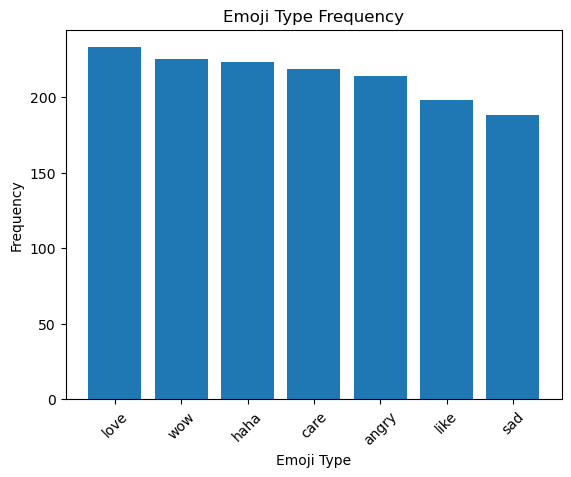

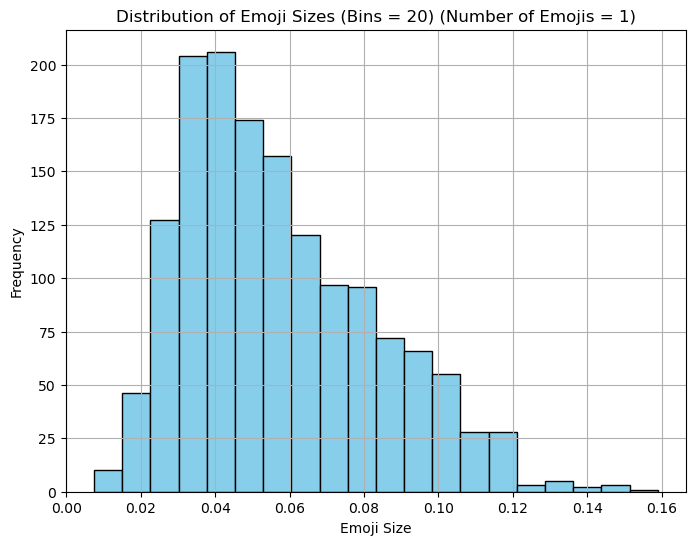

C:\Users\icemo\AppData\Local\Temp\ipykernel_18804\125346851.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(emojiSizesGenerated, shade=True, color='skyblue')


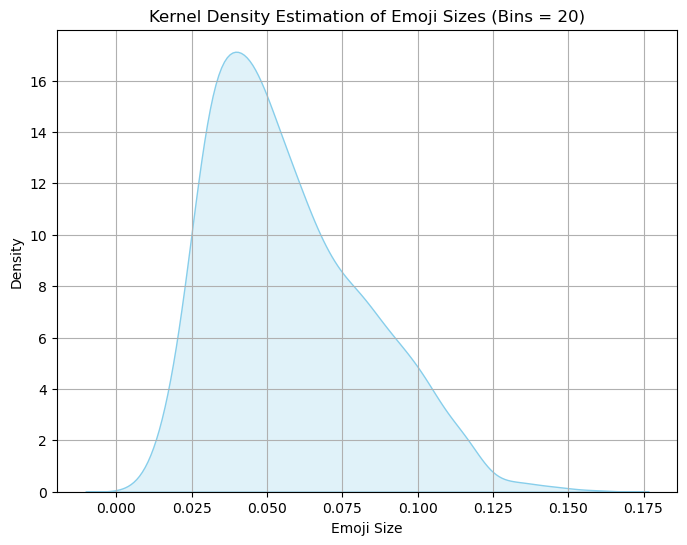

In [12]:
#Calling the function to retrieve images with one emoji inset
emojiImagesOne = {}
returnedFrequenciesGenerated, returnedSizesGenerated = emojiInsetFunc(images, emojis, emojiImagesOne, 1, "Object_Detection_Dataset/", "Classification_Dataset/")

#Calling the functions to display graphs
displayEmojiFrequency(returnedFrequenciesGenerated)
displayEmojiSizes(returnedSizesGenerated, 1)

#Updating the frequency and size dictionaries
for key in returnedFrequenciesGenerated:
    emojiFrequencyGenerated[key] += returnedFrequenciesGenerated[key]
emojiSizesGenerated += returnedSizesGenerated


## Creating Inset Images with Two Emojis

Calling the `emojiInsetFunc` function to create images with two inset emojis. The emoji type frequency bar graph is displayed alongside the emoji size distribution graph and kernel density plot.

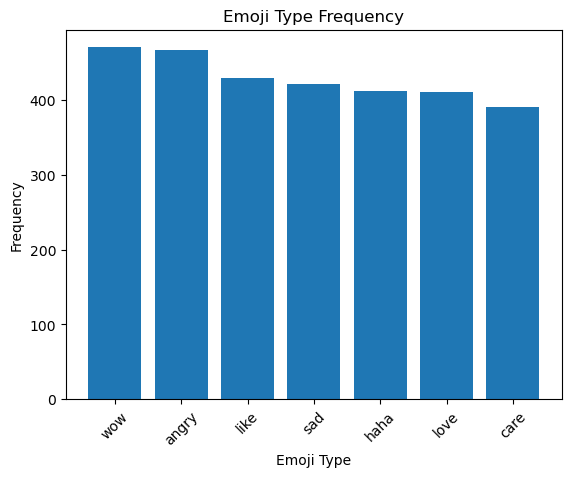

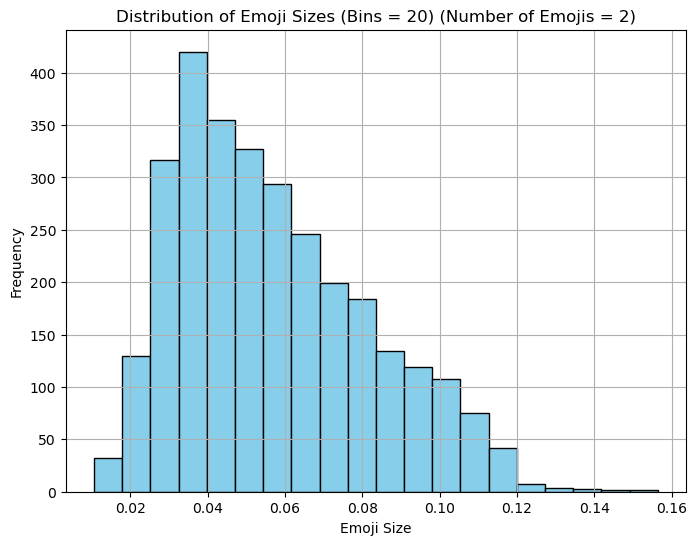

C:\Users\icemo\AppData\Local\Temp\ipykernel_18804\125346851.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(emojiSizesGenerated, shade=True, color='skyblue')


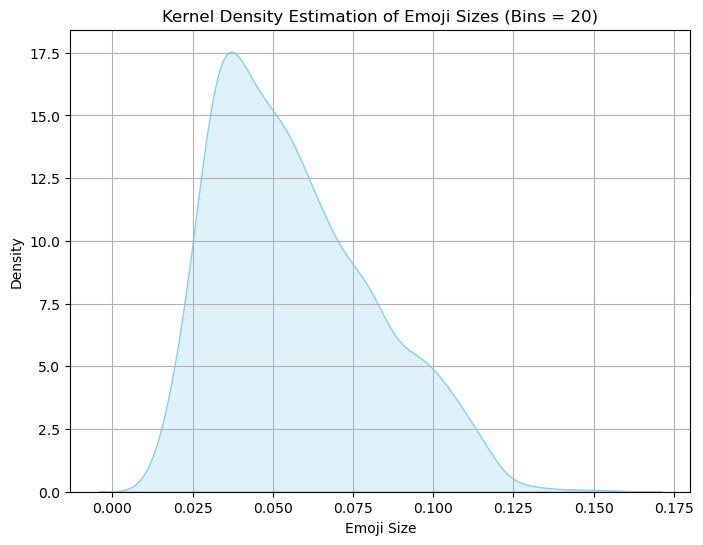

In [13]:
#Calling the function to retrieve images with two emojis inset
emojiImagesTwo = {}
returnedFrequenciesGenerated, returnedSizesGenerated = emojiInsetFunc(images, emojis, emojiImagesTwo, 2, "Object_Detection_Dataset/", "Classification_Dataset/")

#Calling the functions to display graphs
displayEmojiFrequency(returnedFrequenciesGenerated)
displayEmojiSizes(returnedSizesGenerated, 2)

#Updating the frequency and size dictionaries
for key in returnedFrequenciesGenerated:
    emojiFrequencyGenerated[key] += returnedFrequenciesGenerated[key]
emojiSizesGenerated += returnedSizesGenerated

## Creating Inset Images with Three Emojis

Calling the `emojiInsetFunc` function to create images with three inset emojis. The emoji type frequency bar graph is displayed alongside the emoji size distribution graph and kernel density plot.

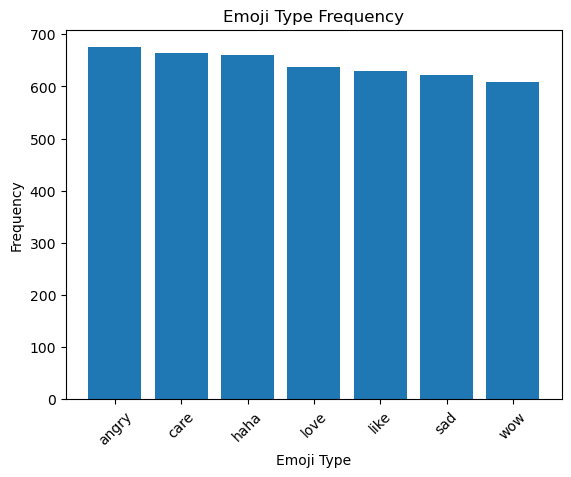

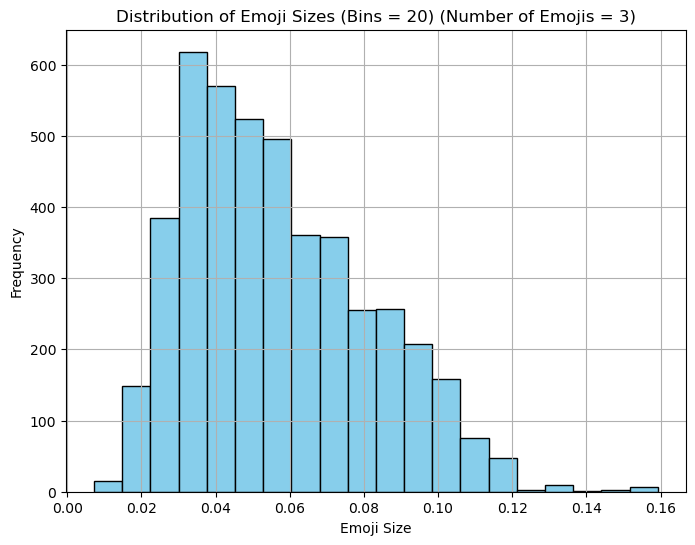

C:\Users\icemo\AppData\Local\Temp\ipykernel_18804\125346851.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(emojiSizesGenerated, shade=True, color='skyblue')


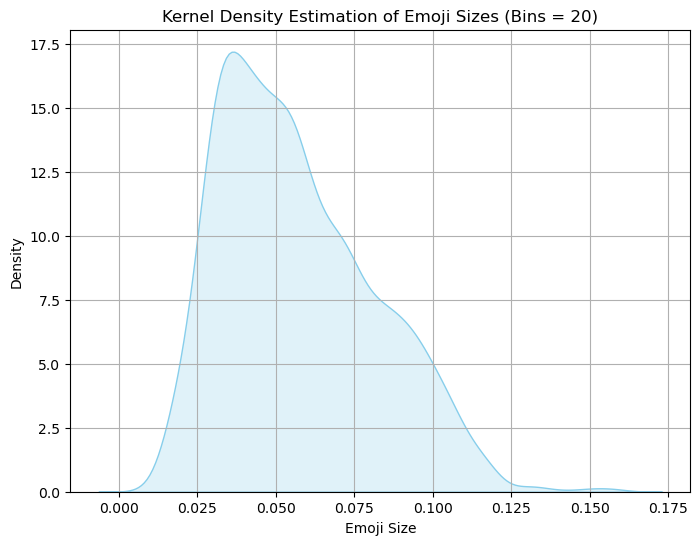

In [14]:
#Calling the function to retrieve images with three emojis inset
emojiImagesThree = {}
returnedFrequenciesGenerated, returnedSizesGenerated = emojiInsetFunc(images, emojis, emojiImagesThree, 3, "Object_Detection_Dataset/", "Classification_Dataset/")

#Calling the functions to display graphs
displayEmojiFrequency(returnedFrequenciesGenerated)
displayEmojiSizes(returnedSizesGenerated, 3)

#Updating the frequency and size dictionaries
for key in returnedFrequenciesGenerated:
    emojiFrequencyGenerated[key] += returnedFrequenciesGenerated[key]
emojiSizesGenerated += returnedSizesGenerated

## Displaying Graphs for Total Frequencies and Sizes

The function to display the graphs are called, this time passing the total emoji types frequencies and total emoji sizes as parameters.

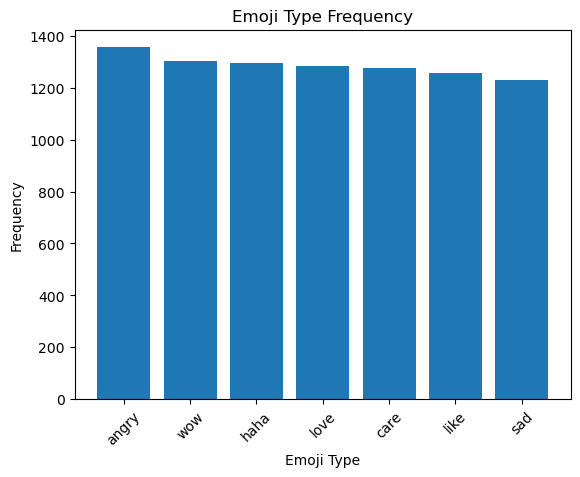

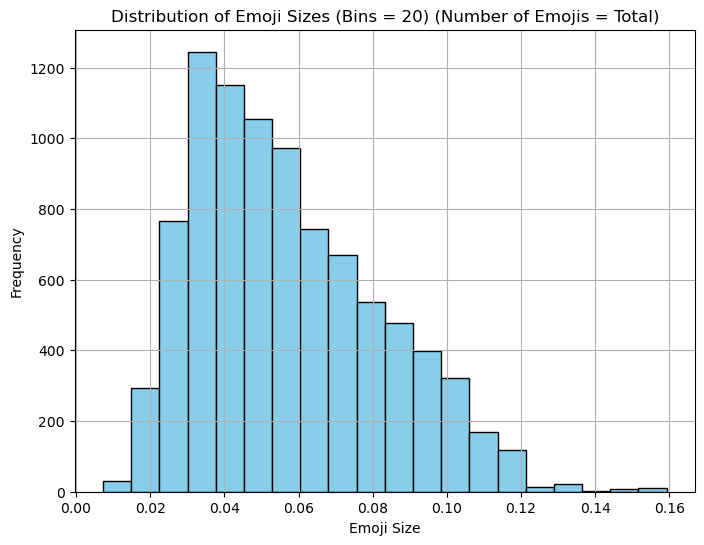

C:\Users\icemo\AppData\Local\Temp\ipykernel_18804\125346851.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(emojiSizesGenerated, shade=True, color='skyblue')


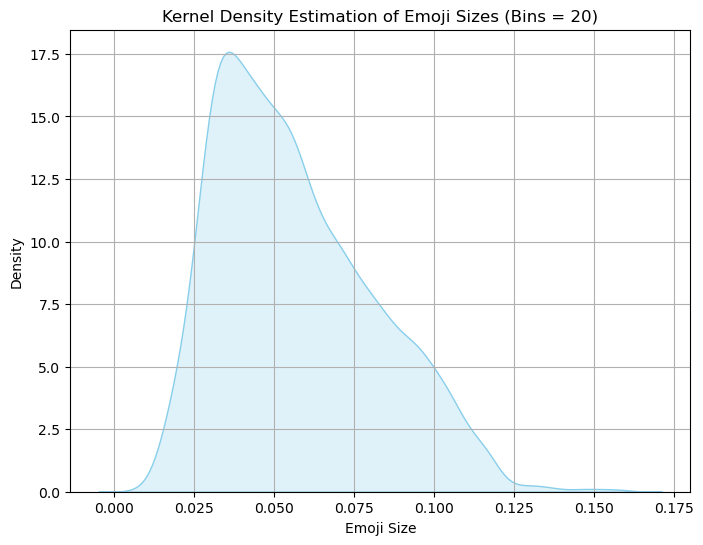

In [15]:
#Calling the functions to display graphs
displayEmojiFrequency(emojiFrequencyGenerated)
displayEmojiSizes(emojiSizesGenerated, "Total")

## Cleaning CSV Files

In [16]:
#Removing the first extra row within the csv files
def remove_first_row(filename):
    with open(filename, 'r') as infile:
        reader = csv.reader(infile)
        next(reader, None)  
        rows = [row for row in reader]  

    with open(filename, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerows(rows)  

remove_first_row('./Object_Detection_Dataset/CSV/Train/labels.csv')
remove_first_row('./Object_Detection_Dataset/CSV/Val/labels.csv')
remove_first_row('./Object_Detection_Dataset/CSV/Test/labels.csv')